<a href="https://colab.research.google.com/github/senthilchandrasegaran/designing-intelligence/blob/main/notebooks/analysis_song_exploder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Analysing Song Exploder Transcripts using Empath

Empath (see [Fast et al., 2016](https://dl.acm.org/doi/10.1145/2858036.2858535)) is a tool for analysing a given corpus of text to identify the occurrence of certain pre-defined linguistic categories (similar to what is provided by LIWC), but also provides us with a way to create our own linguistic categories based on the behaviour we might want to examine. For instance, we might want to look for instances of **_reflective thinking_** in a corpus of designers' interview transcripts. 

In this notebook, we provide a way for you to use Empath to look into a set of such interview transcripts scraped from "[Song Exploder](https://songexploder.net/episodes)", a podcast where "[musicians take apart their songs, and piece by piece, tell the story of how they were made](https://songexploder.net/about)". We will create a new linguistic category called ```"reflection"``` and analyse the transcripts of these interviews to illustrate the idea. However, you can create your own category based on what interests you as a researcher.

Created for the _"Tool Share"_ Moment in the DRS 2022 Festival of Emergence.
 

## First, Some Housekeeping
The cells below are hidden for simplicity. 

You can click on the triangle (pointing right) on the left of this cell to examine the code in the cells below.

For now, simply run them. If you are unfamiliar with the notebook format, you "run" cells by clicking once on the "play" button below, to the left of the text that might say "_[X] cells hidden_". The same instruction applies for any other cell(s) later on in this notebook.

### Installing Libraries and Importing Data Sources
We install and import some necessary libraries in this cell. Simply run the cell below by clicking on the "Play" button on the top left corner (if you cannot see it, hover your mouse pointer over the top left corner of the cell below and it should appear).


In [1]:
!pip install Empath

import glob
import re
import string
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from IPython.display import Markdown, display
from empath import Empath

def printmd(string):
    display(Markdown(string))


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


#### **NOTE:** Re-run above cell if needed.
If you receive a messsage above that states something along the lines of "Restart Runtime", simply run the above cell once again.

### Load All Transcript Datasets
Running the code in the cell below should load 63 files (each a transcript of an interview from the podcast) into the dataframe. If the below function does not work, check your "output" folder to make sure all files are present. 

In [2]:
#@title Mount your Google drive folder
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
#@title Load the transcript files
#@markdown If this cell returns an error, click on "Show code" and make sure the path is correct. You may have to specify 'Shareddrives' instead of MyDrive.
files = glob.glob('/content/drive/MyDrive/designing-intelligence-2022/week-4.6/song-exploder-transcripts/txts/*.txt')

df_list = []

for filename in files:
    df_file = pd.read_csv(filename, sep=';')
    df_list.append(df_file)

df = pd.concat(df_list, axis=0, ignore_index=True)
print("Read", len(files), "files and loaded", df.shape[0], "rows into the dataframe.")

Read 63 files and loaded 2318 rows into the dataframe.


In [4]:
#@title Ignore this cell unless you get an error above
# Uncomment the below command in case of errors in the previous cell.
# np.where(pd.isnull(df))

In [5]:
#@title Examine the dataset
#@markdown The dataset should now be loaded. It consists of around 63 transcripts with a total of over 2300 speech turns loaded into a tabular format. The output below shows the first 5 lines of the data.
df[0:5]

,dataset,session,speaker,speech_turn
0,song_exploder_transcripts,fka-twigs,Hrishikesh,"You’re listening to Song Exploder, where music..."
1,song_exploder_transcripts,fka-twigs,Hrishikesh,This episode contains explicit language. FKA t...
2,song_exploder_transcripts,fka-twigs,twigs,This is FKA twigs. (Music fades out) twigs: T...
3,song_exploder_transcripts,fka-twigs,twigs,"I wrote “Mirrored Heart” with Ethan P. Flynn,..."
4,song_exploder_transcripts,fka-twigs,twigs,(Piano ends)


## Empath Analysis
We will now use the [Empath toolkit](https://github.com/Ejhfast/empath-client/tree/master/empath) to analyse the transcripts by creating a linguistic category and using the category as a lens with which to examine the dataset. 

### Manage Categories in Empath
Below are some functions for keeping track of original categories present in Empath and new ones that you create. We will call these functions if needed.

In [6]:
def check_for_custom_caetgories():
    current_lexicon = Empath()
    empath_original_categories_list = [
         'achievement', 'affection', 'aggression', 'air_travel', 'alcohol', 'ancient', 'anger',
         'animal', 'anonymity', 'anticipation', 'appearance', 'art', 'attractive', 'banking',
         'beach', 'beauty', 'blue_collar_job', 'body', 'breaking', 'business', 'car',
         'celebration', 'cheerfulness', 'childish', 'children', 'cleaning', 'clothing', 'cold',
         'college', 'communication', 'competing', 'computer', 'confusion', 'contentment',
         'cooking', 'crime', 'dance', 'death', 'deception', 'disappointment', 'disgust',
         'dispute', 'divine', 'domestic_work', 'dominant_heirarchical', 'dominant_personality',
         'driving', 'eating', 'economics', 'emotional', 'envy', 'exasperation', 'exercise',
         'exotic', 'fabric', 'family', 'farming', 'fashion', 'fear', 'feminine', 'fight',
         'fire', 'friends', 'fun', 'furniture', 'gain', 'giving', 'government', 'hate',
         'healing', 'health', 'hearing', 'help', 'heroic', 'hiking', 'hipster', 'home',
         'horror', 'hygiene', 'independence', 'injury', 'internet', 'irritability',
         'journalism', 'joy', 'kill', 'law', 'leader', 'legend', 'leisure', 'liquid', 'listen',
         'love', 'lust', 'magic', 'masculine', 'medical_emergency', 'medieval', 'meeting',
         'messaging', 'military', 'money', 'monster', 'morning', 'movement', 'music',
         'musical', 'negative_emotion', 'neglect', 'negotiate', 'nervousness', 'night',
         'noise', 'occupation', 'ocean', 'office', 'optimism', 'order', 'pain', 'party',
         'payment', 'pet', 'philosophy', 'phone', 'plant', 'play', 'politeness', 'politics',
         'poor', 'positive_emotion', 'power', 'pride', 'prison', 'programming', 'rage',
         'reading', 'real_estate', 'religion', 'restaurant', 'ridicule', 'royalty', 'rural',
         'sadness', 'sailing', 'school', 'science', 'sexual', 'shame', 'shape_and_size',
         'ship', 'shopping', 'sleep', 'smell', 'social_media', 'sound', 'speaking', 'sports',
         'stealing', 'strength', 'suffering', 'superhero', 'surprise', 'swearing_terms',
         'swimming', 'sympathy', 'technology', 'terrorism', 'timidity', 'tool', 'torment',
         'tourism', 'toy', 'traveling', 'trust', 'ugliness', 'urban', 'vacation', 'valuable',
         'vehicle', 'violence', 'war', 'warmth', 'water', 'weakness', 'wealthy', 'weapon',
         'weather', 'wedding', 'white_collar_job', 'work', 'worship', 'writing', 'youth', 'zest'
    ]
    empath_original_set = set(empath_original_categories_list)
    empath_current_set = set(lexicon.cats.keys())
    new_categories = empath_current_set.difference(empath_original_set)
    return new_categories
    

def delete_custom_categories():
    cats_to_delete = check_for_custom_caetgories()
    empath_lexicon = Empath()
    for cat in list(cats_to_delete) :
        empath_lexicon.delete_category(cat)
    print("Categories Deleted: ")
    print(cats_to_delete)
        

## Create your own Empath Category
In the cell below, you can create your own category. Make sure the category name is an English word without special characters, as it can improve the outcome.

If needed, replace the text that is assigned to the variable ```category_name``` and the list of seed words assigned to ```category_seed_words``` with a category and a corresponding set of seed words that interest you for the analysis.

In [7]:
#@title Specify Category Name and Seed Words
category_name = 'reflection' #@param {type: 'string'}
category_seed_words = ['believe', 'realise', 'realize', 'retrospect', 'introspect', 'know'] #@param {type: 'raw'}

lexicon = Empath()
lexicon.create_category(category_name, category_seed_words, size=100)

["realize", "realise", "believe", "understand", "Because", "mean", "knowing", "though", "thought", "care", "honestly", "actually", "remember", "knew", "wonder", "admit", "guess", "anymore", "Honestly", "matter", "thinking", "suppose", "trust", "probably", "blame", "assume", "Maybe", "explain", "Obviously", "realized", "seem", "wish", "imagine", "though", "right", "deny", "notice", "doubt", "knows", "anything", "anyway", "realizing", "exactly", "forget", "either", "expect", "seriously", "figured", "pretend", "why", "Actually", "truly", "idea", "seeing", "realised", "Even", "If", "meant", "realise", "bet", "regret", "suspect", "yet", "sure", "happen", "slightest_clue", "understood", "Knowing", "accept", "question", "funny_thing"]


In [8]:
#@title Check for Custom Categories
check_for_custom_caetgories()

{'reflection'}

In [9]:
#@title Delete Custom Categories (if needed)
#@markdown Uncomment the line in this cell if you want to delete all custom categories.
# delete_custom_categories()

In [10]:
#@title Get Words from New Category
#@markdown We will not be using Empath's default matching functions, so that we can do a bit more that what Empath functions allow (identify matching words, create plots, etc.). So we create our own regular expression matching which can definitely be improved upon (see if you want to work on this!)

category_words = lexicon.cats[category_name]
category_words = [w.lower() for w in category_words]
category_words = sorted(list(set(category_words)))
category_words = [w.replace("_", " ") for w in category_words]
print(category_words)

['accept', 'actually', 'admit', 'anymore', 'anything', 'anyway', 'assume', 'because', 'believe', 'bet', 'blame', 'care', 'deny', 'doubt', 'either', 'even', 'exactly', 'expect', 'explain', 'figured', 'forget', 'funny thing', 'guess', 'happen', 'honestly', 'idea', 'if', 'imagine', 'knew', 'knowing', 'knows', 'matter', 'maybe', 'mean', 'meant', 'notice', 'obviously', 'pretend', 'probably', 'question', 'realise', 'realised', 'realize', 'realized', 'realizing', 'regret', 'remember', 'right', 'seeing', 'seem', 'seriously', 'slightest clue', 'suppose', 'sure', 'suspect', 'thinking', 'though', 'thought', 'truly', 'trust', 'understand', 'understood', 'why', 'wish', 'wonder', 'yet']


In [11]:
#@title Add the number of matches to the dataframe (table)
#@markdown Count the number of words in each speech turn that also occur in the category word list.

#@markdown We use total matches here, but we also keep a count of words (for each speech turn) so that we can normalize later if needed.

def make_regex(lex_list):
    separator = '\\b|\\b'
    reg_string = separator.join(lex_list)
    reg_string_whole_word = "\\b" + reg_string + "\\b"
    return reg_string_whole_word

def count_lexicon_terms(sentence, lexicon):
    reg_str = make_regex(lexicon)
    num_matches = len(list(re.finditer(reg_str, sentence.lower())))
    return num_matches

def count_words(sentence):
    words = sentence.split()
    return len(words)
    
def add_measure(df, lex_category_name, lex_category_list, normalize_measure=False):
    if lex_category_name in df.columns :
        print("Column already exists for", lex_category_name, ". Repopulating...")
        df = df.drop(lex_category_name, axis=1)
    column_index = len(df.columns)
    empath_measures = []
    word_counts = []
    for ind, speech_turn in enumerate(list(df['speech_turn'])) :
        if speech_turn != '' and speech_turn != ' ' :
            empath_measure = count_lexicon_terms(speech_turn, lex_category_list)
            num_words = count_words(speech_turn)
            word_counts.append(num_words)
            if normalize_measure :
                empath_measures.append(empath_measure/num_words)
            else :
                empath_measures.append(empath_measure)
    df.insert(column_index, lex_category_name, empath_measures, True)
    if not 'word count' in df.columns :
        df.insert(column_index+1, 'word count', word_counts, True)
    return df

df = add_measure(df, category_name, category_words, normalize_measure=False)
df[0:5]

,dataset,session,speaker,speech_turn,reflection,word count
0,song_exploder_transcripts,fka-twigs,Hrishikesh,"You’re listening to Song Exploder, where music...",0,33
1,song_exploder_transcripts,fka-twigs,Hrishikesh,This episode contains explicit language. FKA t...,0,85
2,song_exploder_transcripts,fka-twigs,twigs,This is FKA twigs. (Music fades out) twigs: T...,2,154
3,song_exploder_transcripts,fka-twigs,twigs,"I wrote “Mirrored Heart” with Ethan P. Flynn,...",9,451
4,song_exploder_transcripts,fka-twigs,twigs,(Piano ends),0,2


### Call the function

In [12]:
#@title Plot Occurrences
#@markdown We will now use a number of plotting functions to plot the proportion of speech turns that have at least one word that occurs in the category word list.

#@markdown We can visualize this proportion at different levels of detail: at the level of the entire dataset, or per session, or separate speakers within a session, or a sequence of turns from the start to the end of the session. 

def plot_cats_by_dataset(df, category, normalize=False):
    dataset_df = df
    dataset_category_df = df[df[category] > 0]
    datasets = sorted(list(set(df['dataset'])))
    num_datasets = len(datasets)
    fig = plt.figure(figsize=[num_datasets,4], dpi=100)
    if normalize == False :
        p=sns.countplot(data=dataset_df, x='dataset', color='#eee', order=datasets)
        p=sns.countplot(data=dataset_category_df, x='dataset', color='#777', order=datasets)
        p.set_title('proportion of ' + category + ' turns')
    else :
        total_turns_list = []
        category_turns_list = []
        for dataset in datasets :
            total_turns = df[df['dataset'] == dataset].shape[0]
            category_turns = dataset_category_df[dataset_category_df['dataset'] == dataset].shape[0]
            total_turns_normalized = 100
            category_turns_normalized = category_turns/total_turns * 100
            total_turns_list.append(total_turns_normalized)
            category_turns_list.append(category_turns_normalized)
        p=sns.barplot(x=datasets, y=total_turns_list, orient='v', color='#eee')
        p=sns.barplot(x = datasets, y=category_turns_list, orient='v', color='#777')
        p.set_title('proportion of ' + category + ' turns')
        
    # plt.savefig('plots/empath'+category+'-turns-count.pdf', bbox_inches='tight')
    plt.show()

def plot_cats_by_session(df, dataset_name, category, color='default', normalize=False):
    dataset_df = df[df['dataset'] == dataset_name]
    dataset_category_df = dataset_df[dataset_df[category] > 0]
    sessions = sorted(list(set(dataset_df['session'])))
    num_sessions = len(sessions)
    fig = plt.figure(figsize=[num_sessions,4], dpi=300)
    if normalize == False :
        p=sns.countplot(data=dataset_df, x='session', color='#eee', order=sessions)
        p=sns.countplot(data=dataset_category_df, x='session', color='#777', order=sessions)
        p.set_title('proportion of ' + category + ' turns')
    else :
        total_turns_list = []
        category_turns_list = []
        for session in sessions :
            total_turns = dataset_df[dataset_df['session'] == session].shape[0]
            category_turns = dataset_category_df[dataset_category_df['session'] == session].shape[0]
            total_turns_normalized = 100
            category_turns_normalized = category_turns/total_turns * 100
            total_turns_list.append(total_turns_normalized)
            category_turns_list.append(category_turns_normalized)
        p=sns.barplot(x=sessions, y=total_turns_list, orient='v', color='#eee')
        p=sns.barplot(x = sessions, y=category_turns_list, orient='v', color='#777')
    p.set_title('proportion of ' + category + ' turns')
    p.set_xticklabels(sessions, rotation=30, ha='right')
    # plt.savefig('plots/empath'+category+'-'+dataset_name+'-turns-count-by-session.pdf', bbox_inches='tight')
    plt.show()

def plot_cats_by_speaker(df, dataset, category):
    sessions = list(set(df[df['dataset'] == dataset]['session']))
    for session in sessions :
        session_df = df[df['session'] == session]
        session_category_df = df[(df['session'] == session) & (df[category] > 0)]
        speakers = sorted(list(set(session_df['speaker'])))
        num_speakers = len(speakers)
        fig = plt.figure(figsize=[num_speakers,4], dpi=100)
        p=sns.countplot(data=session_df, x='speaker', color='#eee', order=speakers)
        p=sns.countplot(data=session_category_df, x='speaker', color='#777', order=speakers)
        p.set_title(category + ' turns count | ' + dataset + ' | ' + session)
        # plt.savefig('plots/empath'+category+'-turns-count-'+ dataset +'-'+ session +'.pdf', bbox_inches='tight')
        plt.show()

def plot_occurrences(input_df, dataset, session, category, range=[]):
    sns.set_style('ticks')
    sns.set_context("paper", font_scale=1.3)
    dataset_df = input_df[input_df['dataset'] == dataset]
    df_all = dataset_df[dataset_df['session'] == session]
    if len(range) == 0 :
        df = df_all.copy()
        start_turn = 0
    else :
        df = df_all[range[0]:range[1]]
        start_turn = range[0]
    category_color = '#777'
    none_color = '#eee'
    palette = [none_color, category_color]
    occurrences = []
    turns = []
    category_type = []
    category_occ = list(df[category])
    for ind, t in enumerate(category_occ) :
        if t > 0 : # category occurs in turn
            occ = 2
            kind = category
        else :
            occ = 1
            kind = 'none'
        category_type.append(kind)
        occurrences.append(occ)
        turns.append(ind + start_turn)
    df_plot = pd.DataFrame(list(zip(turns, occurrences, category_type)),
                           columns =['Turn', 'Category Index', 'Category'])
    fig = plt.figure(figsize=[20, 1], dpi=300)
    p = sns.scatterplot(data = df_plot, x = 'Turn', y = 'Category Index', hue='Category', 
                  hue_order = ['none', category], legend=False,
                  palette = palette, marker="|", s=200, lw=10)
    plt.ylim(0,3)
    plt.yticks([1,2], ['none', category])
    # plt.savefig('plots/'+dataset+'-'+session+'-'+category +'-occurrence-timeline.pdf', bbox_inches='tight')
    plt.show()


def match_lexicon_terms(sentence, lexicon):
    reg_str = make_regex(lexicon)
    reg_matches = re.findall(reg_str, sentence.lower())
    reg_split = re.split(reg_str, sentence.lower())
    ind = 0
    matched_print = ""
    for split_string in reg_split:
        if ind == len(reg_matches) :
            str_to_concat = split_string
        else :
            str_to_concat = split_string + '**' + reg_matches[ind] + '**'
            ind += 1
        matched_print += str_to_concat
    return matched_print
    
def print_lines(df, dataset, session, lexicon, start=1, num_lines=10):
    df1 = df[df['dataset'] == dataset]
    df2 = df1[df1['session'] == session]
    speakers_list = list(df2['speaker'])
    utt = list(df2['speech_turn'])
    end = start + num_lines
    for ind, line in enumerate(utt[start:end]) :
        index = ind + start
        line_matched = match_lexicon_terms(line, lexicon)
        print(str(index)+' : ', end='')
        print(speakers_list[index])
        printmd(line_matched)
        print('----------')
        
def concordance(text, word, width=80, occurrences=10,nospace=False):
    margin = int((width - len(word))/2)
    start = 0
    counter = 0
    while start < len(text) or counter == occurrences:
        ind = text.find(word, start, -1)
        if ind < 0 :
            break
        
        if nospace : 
            
            if ind - margin > 0 :
                print(text[ind-margin:ind+len(word)+margin], ":", str(ind))
            else :
                spaces = ' ' * (margin - ind)
                print(spaces + text[0:ind+len(word)+margin], ":", str(ind))
            
        else :
            
            if ind - margin > 0 :
                left_text = text[ind-margin:ind]
                mid_text = text[ind:ind+len(word)]
                right_text = text[ind+len(word):ind+len(word)+margin]
            else :
                left_text = text[0:ind]
                mid_text = text[ind:ind+len(word)]
                right_text = text[ind+len(word):ind+len(word)+margin]
                
            print(left_text + "  " + mid_text + "  " + right_text, ":", str(ind))
            
        start += ind + len(word)
        counter += 1
        

def print_concordances(df, dataset, session, filter_keywords, match_limit=10, nospace=False):
    df1 = df[df['dataset'] == dataset]
    df2 = df1[df1['session'] == session]
    speakers_list = list(df2['speaker'])
    utt = list(df2['speech_turn'])
    utt_str = ' '.join(utt)
    if len(filter_keywords) > 0 :
        for term in filter_keywords :
            concordance(utt_str, term, width=80, occurrences=match_limit, nospace=nospace)
            print("-" * 80)

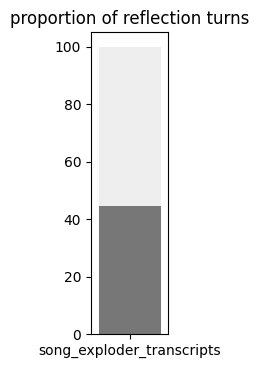

In [13]:
#@title Plot by Dataset
#@markdown plot all speech turns (across all the transcripts in the dataset) with at least one match with the category you just created.
plot_cats_by_dataset(df, category_name, normalize=True)


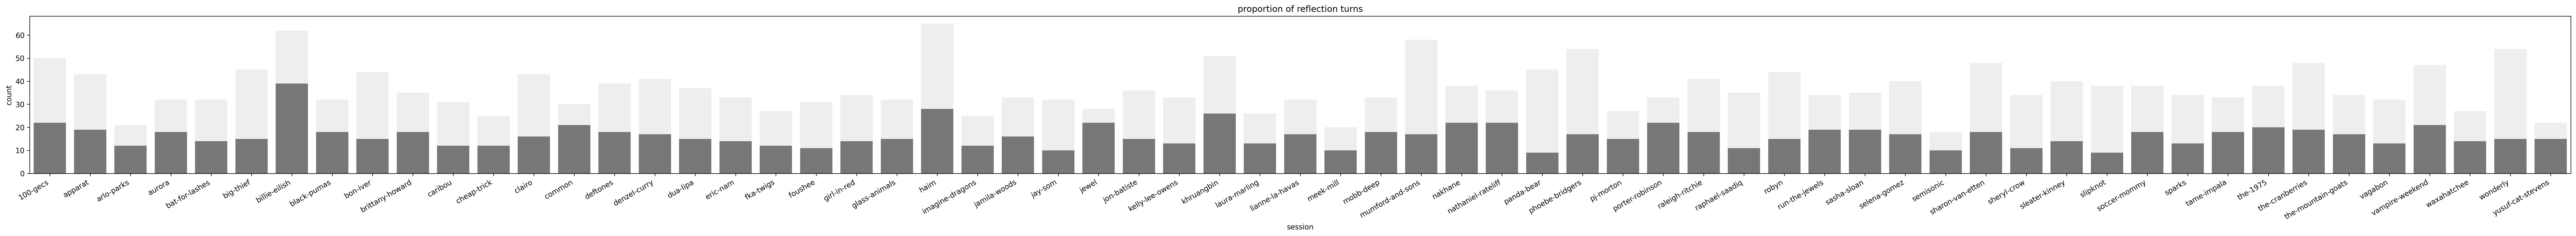

In [14]:
#@title Plot by Session
#@markdown Run the cell below to plot all speech turns (in each session) with at least one match with the category you just created.
#@markdown Click on `normalize` to get a sense of relative proportion, since some sessions may have more or fewer speech turns.
normalize = False #@param {type : 'boolean'}

plot_cats_by_session(df, 'song_exploder_transcripts', category_name, normalize=normalize)


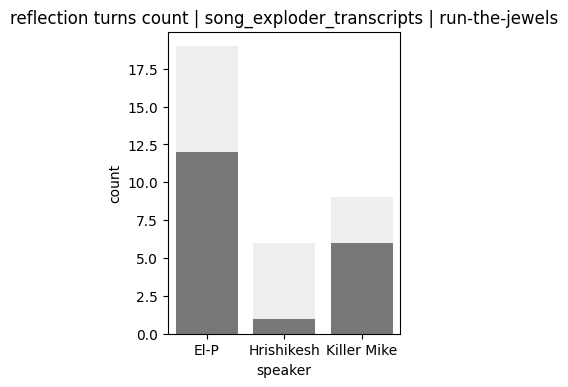

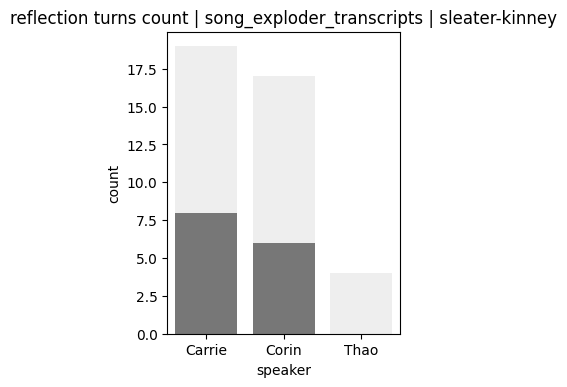

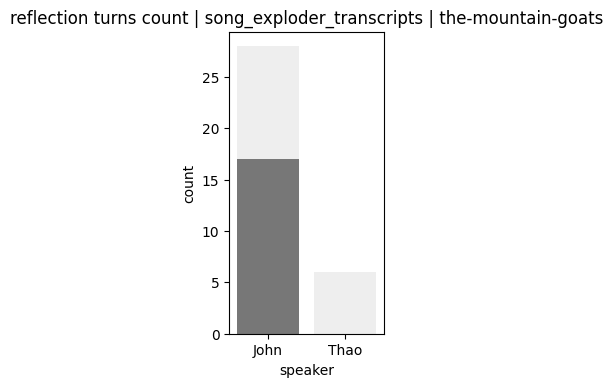

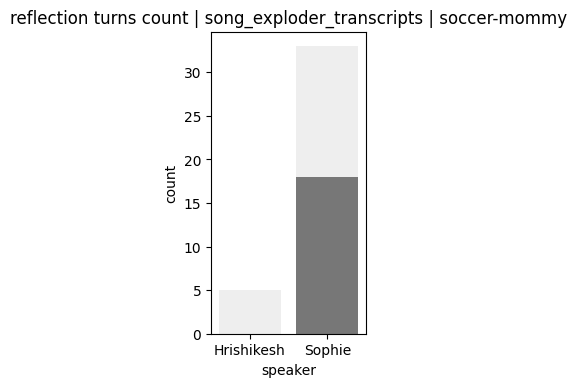

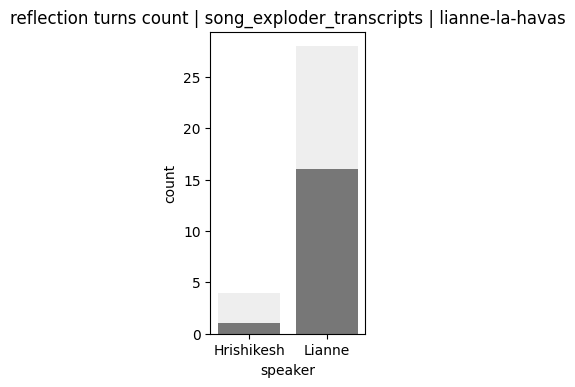

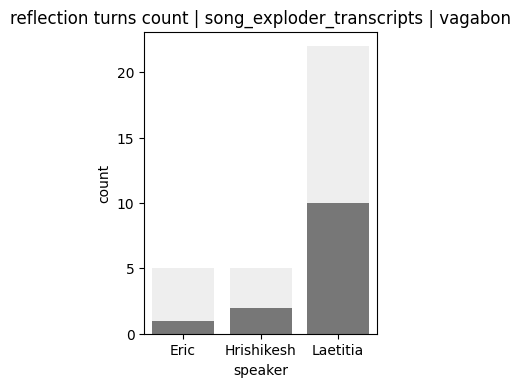

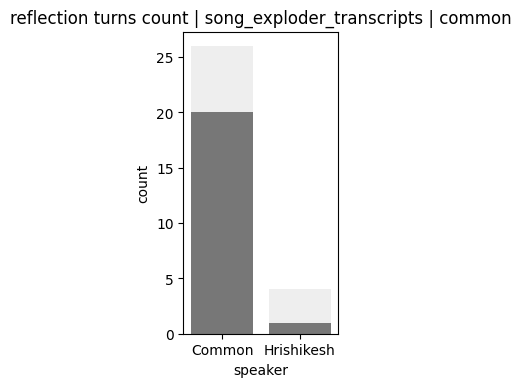

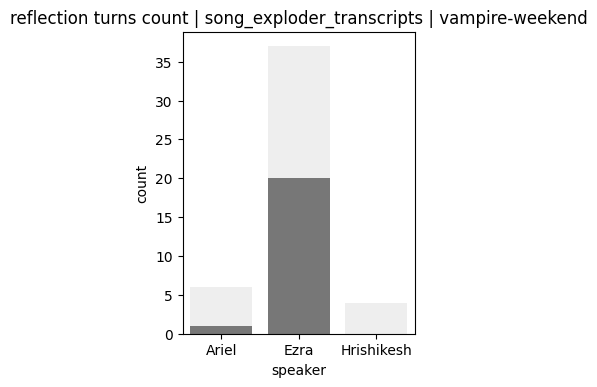

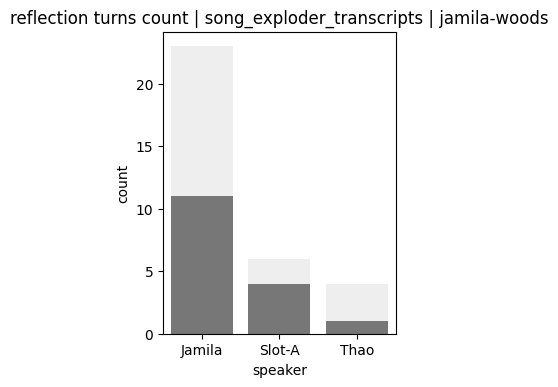

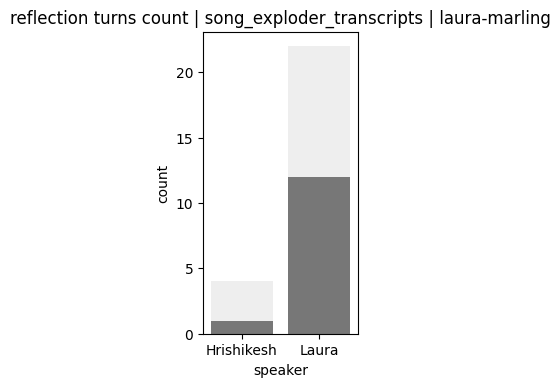

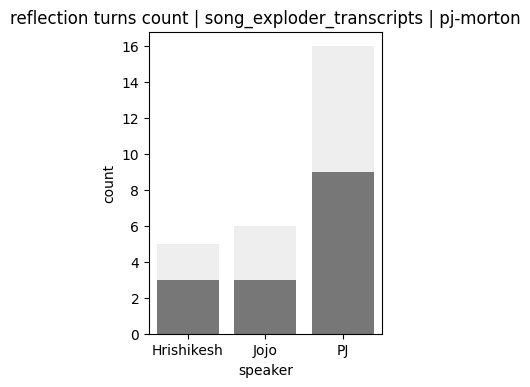

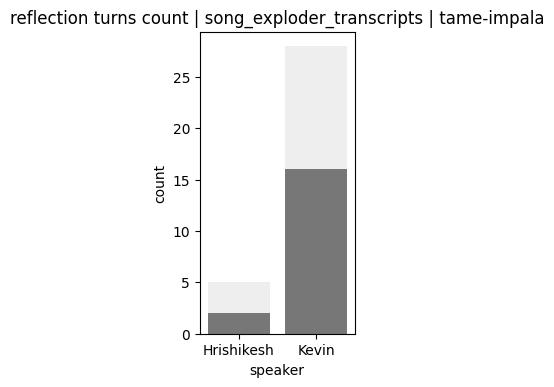

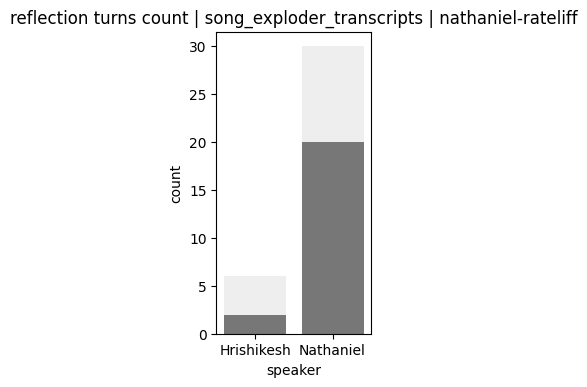

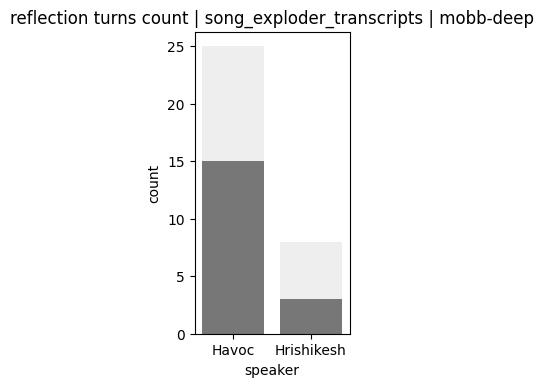

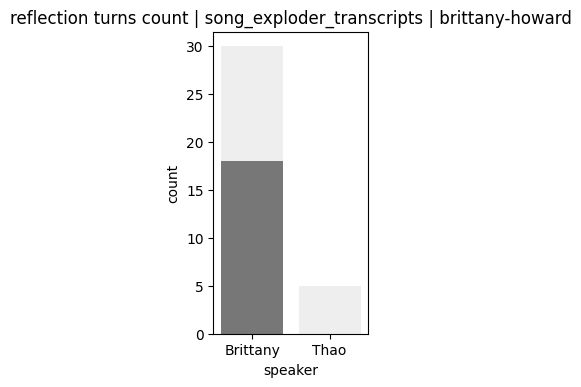

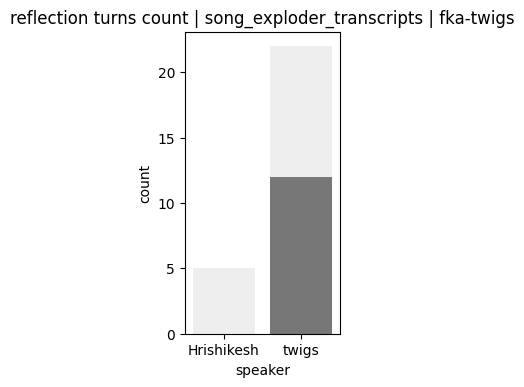

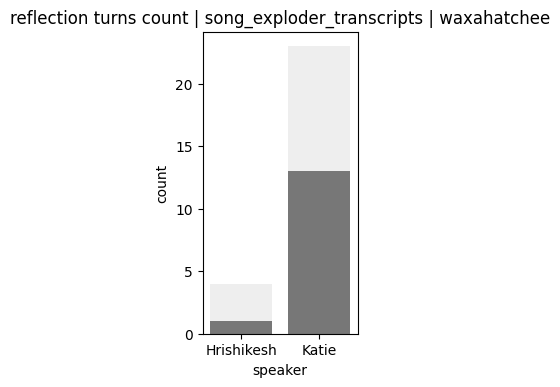

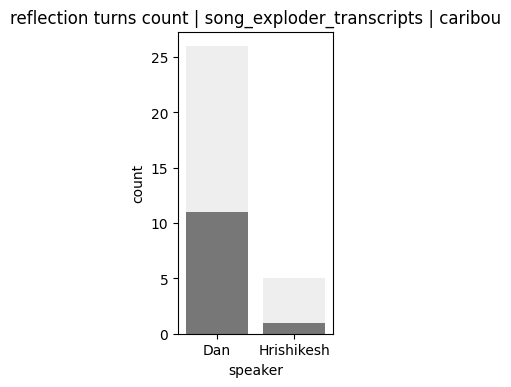

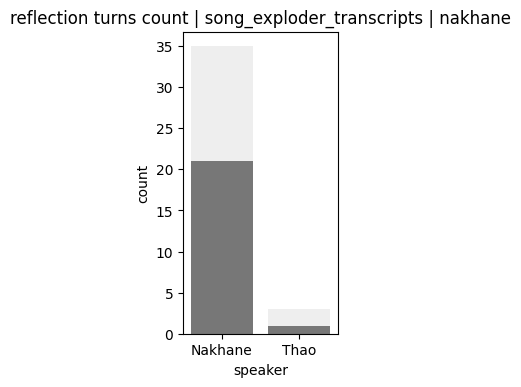

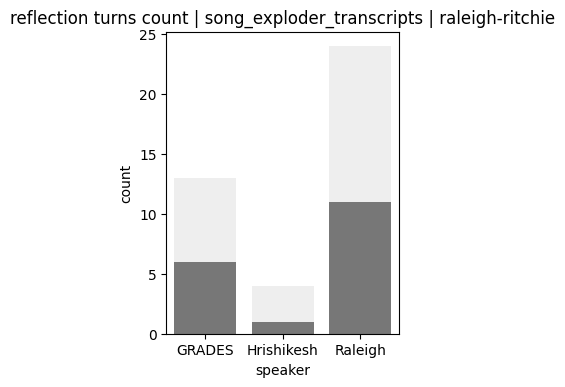

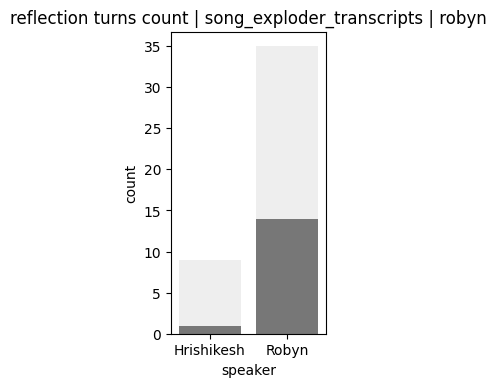

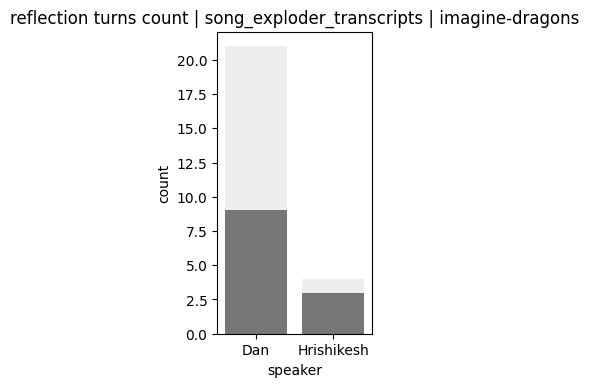

In [ ]:
#@title Plot by Speaker (for each session)
#@markdown Run this cell to create one plot for each session, with the speech turns split up by speaker. The proportion of speech turns with at least one match with your category is shown for each speaker in the set of plots below.

#@markdown NOTE: This can create a *lot* of charts (over 60)
plot_cats_by_speaker(df, 'song_exploder_transcripts', category_name)

In [ ]:
#@title Plot a "timeline" of speech turns
#@markdown Given an interview, this plots a series of vertical "strips" representing the turns from the start to the end of the interview. Turns with at least one match to your category of interest are plotted separately and in a darker colour.
#@markdown Choose the interview name from the dropdown menu.

interview_name = 'the-cranberries' #@param ['raphael-saadiq', 'common', 'deftones', 'nakhane', 'kelly-lee-owens', 'arlo-parks', 'denzel-curry', 'meek-mill', 'semisonic', 'jay-som', 'bon-iver', 'waxahatchee', 'caribou', 'jewel', 'clairo', 'mumford-and-sons', 'laura-marling', 'wonderly', 'sasha-sloan', 'panda-bear', 'robyn', 'sleater-kinney', 'phoebe-bridgers', 'soccer-mommy', 'jon-batiste', 'billie-eilish', 'tame-impala', 'sharon-van-etten', '100-gecs', 'sparks', 'foushee', 'black-pumas', 'big-thief', 'imagine-dragons', 'vagabon', 'nathaniel-rateliff', 'dua-lipa', 'lianne-la-havas', 'selena-gomez', 'sheryl-crow', 'run-the-jewels', 'cheap-trick', 'eric-nam', 'the-1975', 'the-cranberries', 'pj-morton', 'brittany-howard', 'mobb-deep', 'glass-animals', 'apparat', 'khruangbin', 'raleigh-ritchie', 'fka-twigs', 'aurora', 'bat-for-lashes', 'jamila-woods', 'girl-in-red', 'the-mountain-goats', 'haim', 'slipknot', 'yusuf-cat-stevens', 'porter-robinson', 'vampire-weekend'] {type : 'raw'}

plot_occurrences(df, 'song_exploder_transcripts', interview_name, category_name)

### Print sections of the transcript
Prints out sections of the transcript (given a starting line and a number of lines to print) with matches to the category of interest highlighted.

In [ ]:
#@title Print sections of the transcript
#@markdown Prints out sections of the transcript (given a starting line and a number of lines to print) with matches to the category of interest highlighted.

print_lines(df,  'song_exploder_transcripts', interview_name, category_words, start=1, num_lines=5)